- from base GRN, build `cluster-specific GRN` for regvelo
  - SVZ + Tumor
  - SVZ only
- Output : network with coef + p-value

In [1]:
import os
import sys

import mplscience
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# 1. SVZ + Tumor

In [51]:
adata = sc.read_h5ad('../../output/annotated_subset_with_latent.h5ad')
adata

AnnData object with n_obs × n_vars = 51879 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3', 'cnv_leiden', 'cnv_score', 'each_cell_type'

In [3]:
np.max(adata.X)

4177.0

In [52]:
with open('../../output/hvgs.txt') as f:
    hvgs = f.read().splitlines()

keep_indices = [adata.var_names.get_loc(gene) for gene in hvgs]
adata = adata[:, keep_indices].copy()
adata

AnnData object with n_obs × n_vars = 51879 × 2000
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3', 'cnv_leiden', 'cnv_score', 'each_cell_type',

In [15]:
np.random.seed(777)
threshold = 10000
target_total = 30000
counts = adata.obs.cell_type.value_counts()

keep_types = counts[counts < threshold].index
subsample_types = counts[counts >= threshold].index

total_small_cells = counts[keep_types].sum()
remaining_cells = target_total - total_small_cells

if len(subsample_types) > 0:
    cells_per_large_pop = remaining_cells // len(subsample_types)

keep_mask = adata.obs.cell_type.isin(keep_types)

for cell_type in subsample_types:
    cells_this_type = adata.obs[adata.obs.cell_type == cell_type].index
    sampled_cells = np.random.choice(cells_this_type, size=cells_per_large_pop, replace=False)
    keep_mask |= adata.obs.index.isin(sampled_cells)


In [36]:
adata = adata[keep_mask].copy()
adata

AnnData object with n_obs × n_vars = 30000 × 2000
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'leiden', 'developing_human_brain_anno', 'developing_human_brain_conf_score', 'human_adultaged_hippocampus_anno', 'human_adultaged_hippocampus_conf_score', 'human_longitudinal_hippocampus_anno', 'human_longitudinal_hippocampus_conf_score', 'gbmap_ref_model_anno', 'gbmap_ref_model_conf_score', 'gbmap_ref_hvg_anno', 'gbmap_ref_hvg_conf_score', 'cell_type', 'cas_cell_type_score_1', 'cas_cell_type_name_1', 'cas_cell_type_label_1', 'cas_cell_type_score_2', 'cas_cell_type_name_2', 'cas_cell_type_label_2', 'cas_cell_type_score_3', 'cas_cell_type_name_3', 'cas_cell_type_label_3', 'cnv_leiden', 'cnv_score', 'each_cell_type',

In [8]:
base_GRN = pd.read_parquet('../../output/base_GRN_from_bulkATAC.parquet')
base_GRN

,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009754_100010255,DNMBP,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr10_100185824_100186325,ERLIN1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_100186342_100186843,ERLIN1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr10_100229367_100229868,CHUK,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_100267465_100267966,CWF19L1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21863,chrY_20575376_20575877,EIF1AY,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21864,chrY_2841332_2841833,RPS4Y1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21865,chrY_2935076_2935577,ZFY,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
21866,chrY_7273679_7274180,PRKY,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
oracle = co.Oracle()

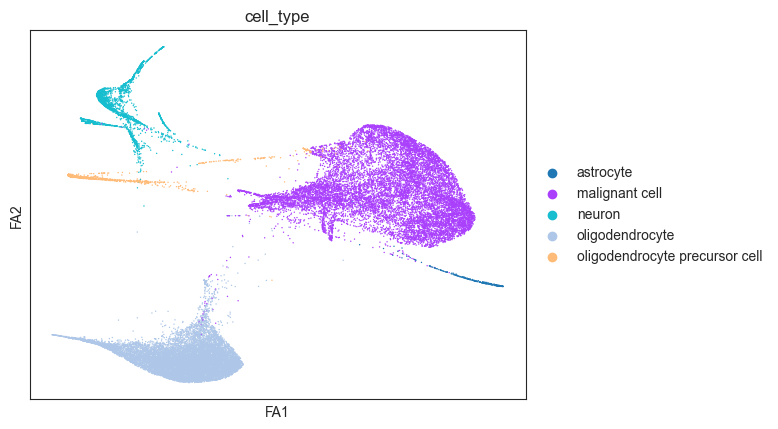

In [18]:
sc.pl.draw_graph(adata, color = 'cell_type')

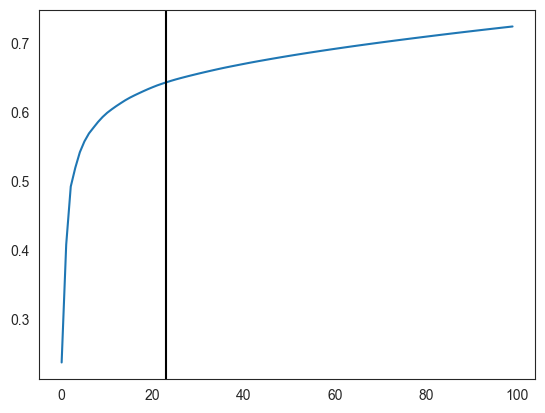

23


In [38]:
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="cell_type", embedding_name="X_draw_graph_fa")
oracle.import_TF_data(TF_info_matrix=base_GRN)

oracle.perform_PCA()

plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [39]:
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

In [40]:
links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10, verbose_level=10)
links.to_hdf5(file_path= "../../output/links_tnl.celloracle.links")

  0%|          | 0/5 [00:00<?, ?it/s]

Inferring GRN for astrocyte...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for malignant cell...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for neuron...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for oligodendrocyte...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for oligodendrocyte precursor cell...


  0%|          | 0/1020 [00:00<?, ?it/s]

- to include as many TF-target, don't filter with threshold

In [45]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=len(links.links_dict['malignant cell']))
df = links.filtered_links['malignant cell'].reset_index(drop=True)
df.to_csv('../../output/grn_co_tumor.csv', index=False)

- filter threshold for network analysis provided in cell oracle

In [47]:
links = co.load_hdf5("../../output/links_tnl.celloracle.links")
links.filter_links(threshold_number=10000) # default
links.get_network_score()

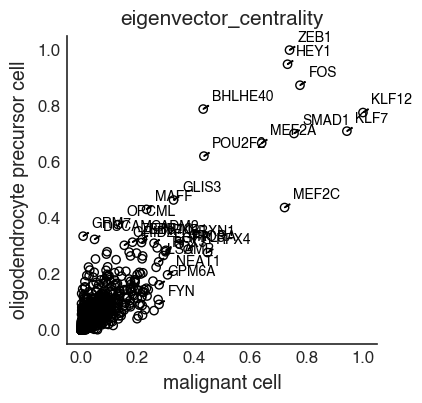

In [48]:
with mplscience.style_context():
    links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="malignant cell", cluster2="oligodendrocyte precursor cell",
                               percentile=98,)

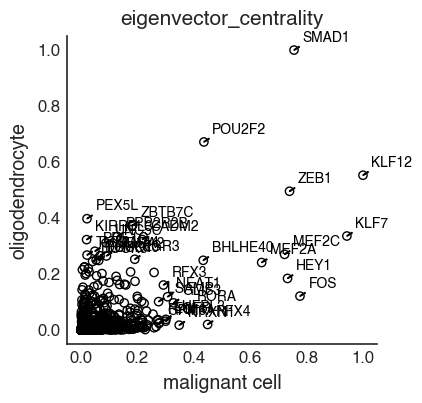

In [49]:
with mplscience.style_context():
    links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="malignant cell", cluster2="oligodendrocyte",
                               percentile=98,)

# 2. SVZ only

In [ ]:
adata = sc.read_h5ad('../../output/annotated_subset_with_latent.h5ad')

keep_indices = [adata.var_names.get_loc(gene) for gene in hvgs]
adata = adata[:, keep_indices].copy()
adata = adata[adata.obs.tissue == "SVZ"].copy()

In [56]:
oracle = co.Oracle()

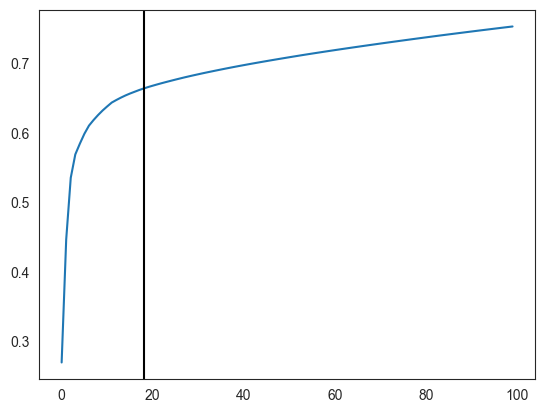

18


In [57]:
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="cell_type", embedding_name="X_draw_graph_fa")
oracle.import_TF_data(TF_info_matrix=base_GRN)

oracle.perform_PCA()

plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [58]:
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=16)

In [59]:
links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10, verbose_level=10)
links.to_hdf5(file_path= "../../output/links_tnl_svz.celloracle.links")

  0%|          | 0/5 [00:00<?, ?it/s]

Inferring GRN for astrocyte...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for malignant cell...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for neuron...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for oligodendrocyte...


  0%|          | 0/1020 [00:00<?, ?it/s]

Inferring GRN for oligodendrocyte precursor cell...


  0%|          | 0/1020 [00:00<?, ?it/s]

In [61]:
links.filter_links(threshold_number=10000) # default
links.get_network_score()

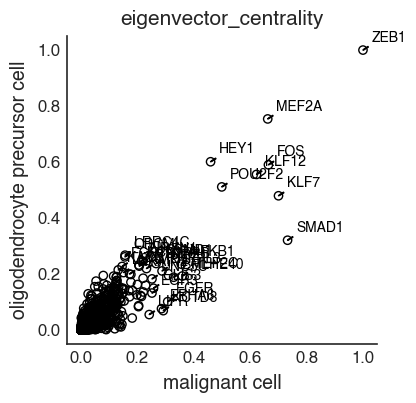

In [62]:
with mplscience.style_context():
    links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="malignant cell", cluster2="oligodendrocyte precursor cell",
                               percentile=98,)

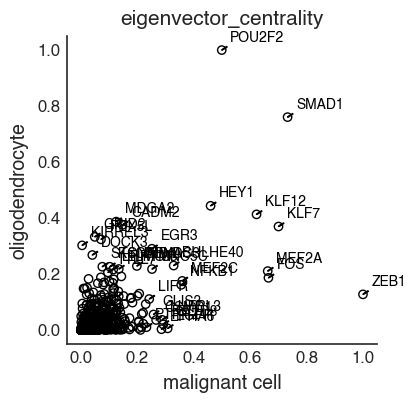

In [63]:
with mplscience.style_context():
    links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="malignant cell", cluster2="oligodendrocyte",
                               percentile=98,)

In [ ]:
#